# Intelligent PEA Workbook Report - 06

In [20]:
# === Actionable Insights (LLM Synthesis) ======================================
# Place this cell in PEA_Workbook_Report.ipynb BEFORE the report build cell.
# Requires: pandas, pyyaml, openai  (pip install pandas pyyaml openai)

import os, json, re
from pathlib import Path
from datetime import datetime, timezone
import pandas as pd
import yaml

# ---------- helpers ----------
def find_project_root(max_up=8):
    p = Path.cwd()
    for _ in range(max_up):
        if (p / "configs").exists() and ((p / "src").exists() or (p / "notebooks").exists()):
            return p
        p = p.parent
    return Path.cwd()

def slugify(s: str) -> str:
    return re.sub(r"[^0-9a-zA-Z]+","-", (s or "").strip().lower()).strip("-") or "unknown"

ROOT = find_project_root()

def _resolve_outputs_dir():
    run_yaml = ROOT / "configs" / "run.yaml"
    if not run_yaml.exists():
        raise FileNotFoundError(f"Missing configs/run.yaml at {run_yaml}")
    cfg = yaml.safe_load(run_yaml.read_text(encoding="utf-8")) or {}
    state = (cfg.get("current_state") or "").strip()
    if not state:
        raise ValueError("configs/run.yaml has no 'current_state'.")
    slug = slugify(state)
    cand1 = ROOT / "outputs" / f"{slug}-state"
    cand2 = ROOT / "outputs" / slug
    if cand1.exists(): return state, cand1
    if cand2.exists(): return state, cand2
    # If neither exists, create the -state folder so the user sees exactly where we looked
    cand1.mkdir(parents=True, exist_ok=True)
    return state, cand1

STATE, OUT_DIR = _resolve_outputs_dir()
print(f"Using outputs dir: {OUT_DIR}")

# ---------- load context (pea_summaries.csv) ----------
ctx_path = OUT_DIR / "pea_summaries.csv"
if not ctx_path.exists():
    raise FileNotFoundError(f"Context file not found: {ctx_path}")
ctx_df = pd.read_csv(ctx_path)
if ctx_df.empty:
    raise ValueError(f"Context file is empty: {ctx_path}")

# Pick latest row by timestamp if present
if "timestamp_utc" in ctx_df.columns:
    ctx_df = ctx_df.sort_values("timestamp_utc")
ctx_row = ctx_df.iloc[-1].to_dict()

SUBJECT = str(ctx_row.get("subject", "")).strip()
STATE_CTX = str(ctx_row.get("state", STATE)).strip()
ISSUE   = str(ctx_row.get("issue_focus", "")).strip()
SUMMARY = str(ctx_row.get("summary", "")).strip()

if not SUBJECT or not STATE_CTX or not ISSUE:
    raise ValueError("Context row missing required fields (subject/state/issue_focus).")

# ---------- load stakeholders with engagement strategies ----------
eng_path = OUT_DIR / "pea_stakeholder_scores_mapping_engage.csv"
if not eng_path.exists():
    raise FileNotFoundError(f"Stakeholder engagement file not found: {eng_path}")

eng_df = pd.read_csv(eng_path)
if eng_df.empty:
    raise ValueError(f"Stakeholder engagement file is empty: {eng_path}")

# Normalize expected columns (do not fail if extras exist)
expected_cols = [
    "stakeholder_type","entity","category",
    "power","interest","threat","collab",
    "engagement_strategy","justification","source_ref"
]
for c in expected_cols:
    if c not in eng_df.columns:
        # Keep missing ones as empty strings to avoid errors; LLM can still work
        eng_df[c] = ""

# Trim + compress for prompt (avoid huge token use)
def _compress_for_prompt(df: pd.DataFrame, max_rows=150) -> pd.DataFrame:
    cols = [
        "stakeholder_type","entity","category",
        "power","interest","threat","collab","engagement_strategy"
    ]
    slim = df[cols].copy()
    # Prefer rows with non-empty engagement_strategy first, then by power/interest descending
    power_map  = {"Lo":1,"Med":2,"Hi":3}
    interest_map = {"Lo":1,"Med":2,"Hi":3}
    slim["__p"] = slim["power"].map(power_map).fillna(0)
    slim["__i"] = slim["interest"].map(interest_map).fillna(0)
    slim = slim.sort_values(["engagement_strategy","__p","__i"], ascending=[False, False, False])
    slim = slim.head(max_rows).drop(columns=["__p","__i"])
    return slim

prompt_table = _compress_for_prompt(eng_df, max_rows=150)

# Also compute quick meta to give the model some structure without sending everything
def _meta_snapshot(df: pd.DataFrame) -> dict:
    def _freq(col):
        return df[col].value_counts(dropna=False).to_dict() if col in df.columns else {}
    return {
        "counts_by_category": _freq("category"),
        "counts_by_type": _freq("stakeholder_type"),
        "power_dist": _freq("power"),
        "interest_dist": _freq("interest"),
        "threat_dist": _freq("threat"),
        "collab_dist": _freq("collab"),
        "total_rows": int(df.shape[0]),
    }

META = _meta_snapshot(eng_df)

# ---------- build LLM prompts ----------
SYSTEM_PROMPT = """You are a senior Political Economy Advisor.
Produce a precise, decision-ready synthesis. Be politically smart, cautious with assumptions, and avoid any private personal data.
Ground your recommendations in the provided context and stakeholder mapping with engagement strategies.
Output must be actionable, concise, and structured."""

USER_PROMPT = f"""
Context:
- Subject: {SUBJECT}
- State/Location: {STATE_CTX}
- Issue Focus: {ISSUE}

Latest 10-line summary (for background):
---
{SUMMARY}
---

Stakeholder mapping snapshot (distributions/shape):
{json.dumps(META, ensure_ascii=False)}

Stakeholder rows (abridged; up to 150), CSV-like JSONL with key columns:
{prompt_table.to_json(orient="records", force_ascii=False)}

Task:
Using ONLY the information above, synthesize the most critical actionable insights. Your output should:
1) Summarize the main challenges and opportunities around the issue focus.
2) Identify priority actor groups or specific stakeholders and why they matter (tie to power/interest/threat/collab patterns).
3) Distill concrete engagement strategies per priority group/type, referencing the mapped scores and the provided 'engagement_strategy' cells (refine/improve where useful).
4) Flag key risks/constraints and how they should shape engagements.
5) Provide step-by-step recommendations (near-term 30–90 days; medium-term 3–9 months).

Format:
- Use clear markdown with headings: **Challenges & Opportunities**, **Priority Stakeholders**, **Engagement Strategies**, **Risks & Constraints**, **Step-by-Step Recommendations**.
- Keep to ~500–800 words.
"""

# ---------- LLM call with graceful fallback ----------
def _load_openai():
    cfg_path = ROOT / "configs" / "config.json"
    cfg = {}
    if cfg_path.exists():
        try:
            cfg = json.loads(cfg_path.read_text(encoding="utf-8")) or {}
        except Exception:
            cfg = {}
    key = (os.getenv("OPENAI_API_KEY") or os.getenv("OPEN_API_KEY")
           or cfg.get("OPENAI_API_KEY") or cfg.get("OPEN_API_KEY"))
    base = os.getenv("OPENAI_BASE_URL") or cfg.get("ENVIRONMENT_URL") or cfg.get("OPENAI_BASE_URL")
    model = cfg.get("MODEL", "gpt-4o-mini")
    if not key:
        return None, None, "No API key in env or configs/config.json."
    try:
        from openai import OpenAI
        client = OpenAI(api_key=key, base_url=base) if base else OpenAI(api_key=key)
        return client, model, None
    except Exception as e:
        return None, None, f"OpenAI init failed: {e}"

def _heuristic_insights():
    # Very small offline fallback if LLM unavailable
    top_by_power = eng_df.copy()
    pm = {"Lo":1,"Med":2,"Hi":3}
    top_by_power["p"] = top_by_power["power"].map(pm).fillna(0)
    top_by_power = top_by_power.sort_values("p", ascending=False).head(8)
    bullets = []
    for _, r in top_by_power.iterrows():
        bullets.append(f"- **{r.get('entity','(entity)')}** "
                       f"(Power={r.get('power')}, Interest={r.get('interest')}, "
                       f"Threat={r.get('threat')}, Collab={r.get('collab')}): "
                       f"{(r.get('engagement_strategy') or 'Engage via targeted consultations and coalition-building.')}")
    return "\n".join([
        "## Challenges & Opportunities",
        "- Offline heuristic summary due to LLM unavailability.",
        "",
        "## Priority Stakeholders",
        *bullets[:1],  # show top section header then bullets in next section
        "",
        "## Engagement Strategies",
        *bullets,
        "",
        "## Risks & Constraints",
        "- Potential resistance from entrenched interests; capacity and coordination gaps.",
        "",
        "## Step-by-Step Recommendations",
        "1) Convene quick wins with high-power/high-interest actors.",
        "2) Manage threats via transparency and oversight coalitions.",
        "3) Build broader support through informed communications.",
    ])

client, model, init_err = _load_openai()
if client is None:
    insights_md = _heuristic_insights()
    print("LLM unavailable:", init_err)
else:
    try:
        resp = client.chat.completions.create(
            model=model,
            temperature=0.25,
            messages=[
                {"role":"system","content": SYSTEM_PROMPT},
                {"role":"user","content": USER_PROMPT}
            ],
        )
        insights_md = (resp.choices[0].message.content or "").strip()
        if not insights_md:
            insights_md = _heuristic_insights()
            print("⚠️ Empty LLM response; used heuristic fallback.")
    except Exception as e:
        insights_md = _heuristic_insights()
        print("⚠️ LLM call failed; used heuristic fallback. Error:", e)

# ---------- save + display ----------
out_md = OUT_DIR / "PEA_Actionable_Insights.md"
ts = datetime.now(timezone.utc).isoformat(timespec="seconds").replace("+00:00","Z")

prefix = [
    "# Actionable Insights",
    f"**Subject:** {SUBJECT}",
    f"**State:** {STATE_CTX}",
    f"**Issue Focus:** {ISSUE}",
    f"**Generated:** {ts}",
    "",
]
out_md.write_text("\n".join(prefix) + insights_md + "\n", encoding="utf-8")

# Expose a variable you can reuse in the next cell if you want to append into the report:
INSIGHTS_TEXT = "\n".join(prefix) + insights_md

print("=== Actionable Insights ===\n")
print(INSIGHTS_TEXT)
print("\nSaved to:", out_md)

Using outputs dir: /Users/olusojiapampa/Library/Mobile Documents/com~apple~CloudDocs/Documents/Proposals/PACE/PEAIM/PEAIM_clean_full/outputs/kaduna-state
=== Actionable Insights ===

# Actionable Insights
**Subject:** Climate Governance
**State:** Kaduna State
**Issue Focus:** Fund allocation to Forestry
**Generated:** 2025-10-05T02:21:30Z
# Climate Governance in Kaduna State: Fund Allocation to Forestry

## Challenges & Opportunities

### Challenges
1. **Deforestation and Environmental Degradation**: Kaduna State is experiencing significant environmental challenges, necessitating urgent action in climate governance and forestry fund allocation.
2. **Bureaucratic Inefficiencies**: Competing budget priorities and inefficiencies within government institutions hinder effective fund allocation for forestry initiatives.
3. **Vested Interests**: Resistance from stakeholders reliant on unsustainable logging and agricultural practices poses a significant threat to proposed reforms.
4. **Inform

Using outputs dir: /Users/olusojiapampa/Library/Mobile Documents/com~apple~CloudDocs/Documents/Proposals/PACE/PEAIM/PEAIM_clean_full/outputs/kaduna-state


# Political Economy Analysis Workbook

**Date:** 2025-10-05T05:35:00+00:00

## 1) Context

**Subject:** Climate Governance  
**State:** Kaduna State  
**Issue Focus:** Fund allocation to forestry

**10-line Summary:**

### Climate Governance • Kaduna State • Fund allocation to forestry

1. Kaduna State faces significant deforestation challenges, impacting biodiversity and climate resilience, making forestry fund allocation critical for sustainable development.  
2. Key institutions include the Kaduna State Ministry of Environment, the State House of Assembly, and the Forestry Research Institute of Nigeria, which influence policy and budget decisions.  
3. Non-state actors such as local CSOs, environmental NGOs, and private sector stakeholders play a role in advocacy, while international development partners provide funding and technical support.  
4. Incentives for forestry funding include potential carbon credit revenues, while constraints involve bureaucratic inefficiencies and competing budget priorities; veto points exist within the legislature.  
5. The state budget includes specific allocations for environmental initiatives, with policy hooks in the Kaduna State Climate Change Policy and the National Forestry Policy.  
6. Opportunities arise from increased global focus on climate action and potential partnerships with NGOs and private investors for sustainable forestry projects.  
7. Risks include pushback from agricultural lobbies prioritizing land for farming over forestry and potential conflicts over land use rights.  
8. Information gaps exist regarding the economic value of forests and capacity limitations in local governance structures to effectively manage forestry funds.  
9. Likely winners include environmental NGOs and communities benefiting from sustainable practices, while agricultural interests may face losses from reduced land access.  
10. Strategic implication: Strengthening governance frameworks for forestry fund allocation can enhance climate resilience and promote sustainable economic growth in Kaduna State.

## 2) Stakeholder Maps

**Power vs. Interest**

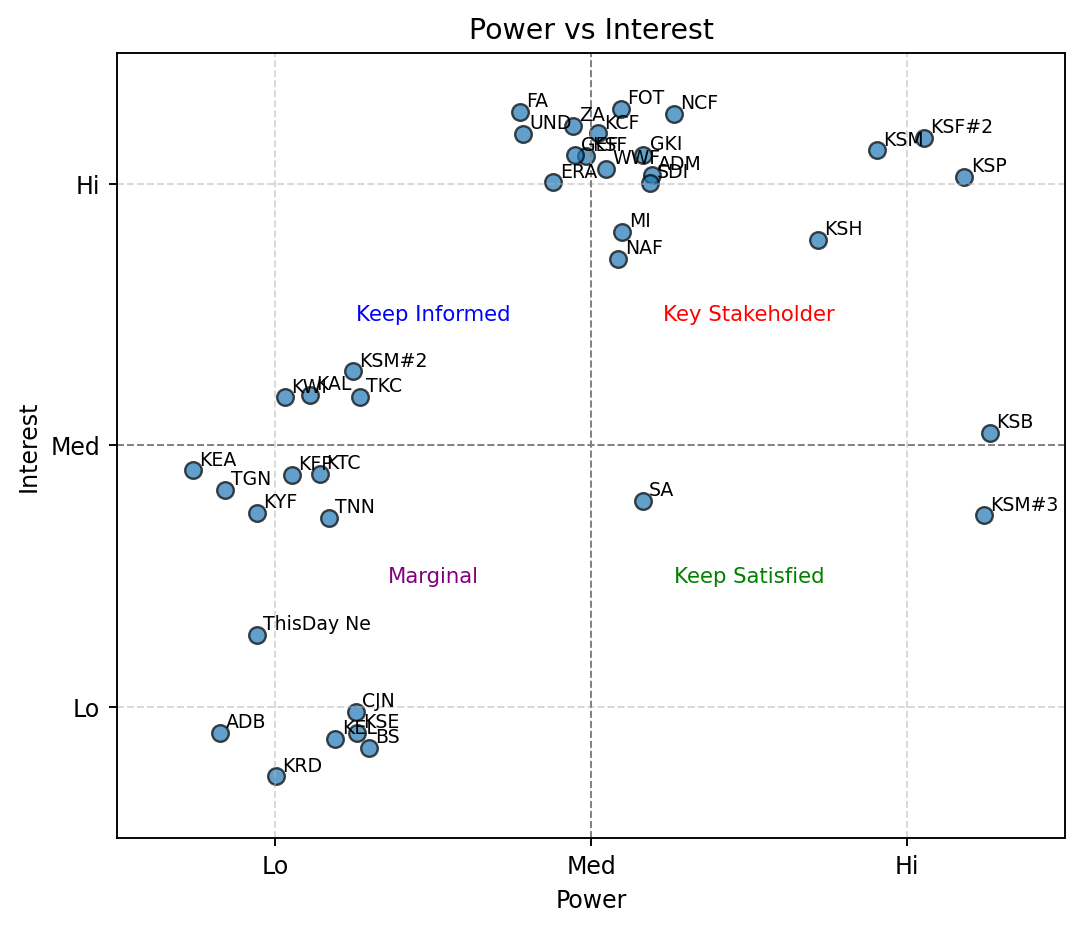

**Threat vs. Collaboration**

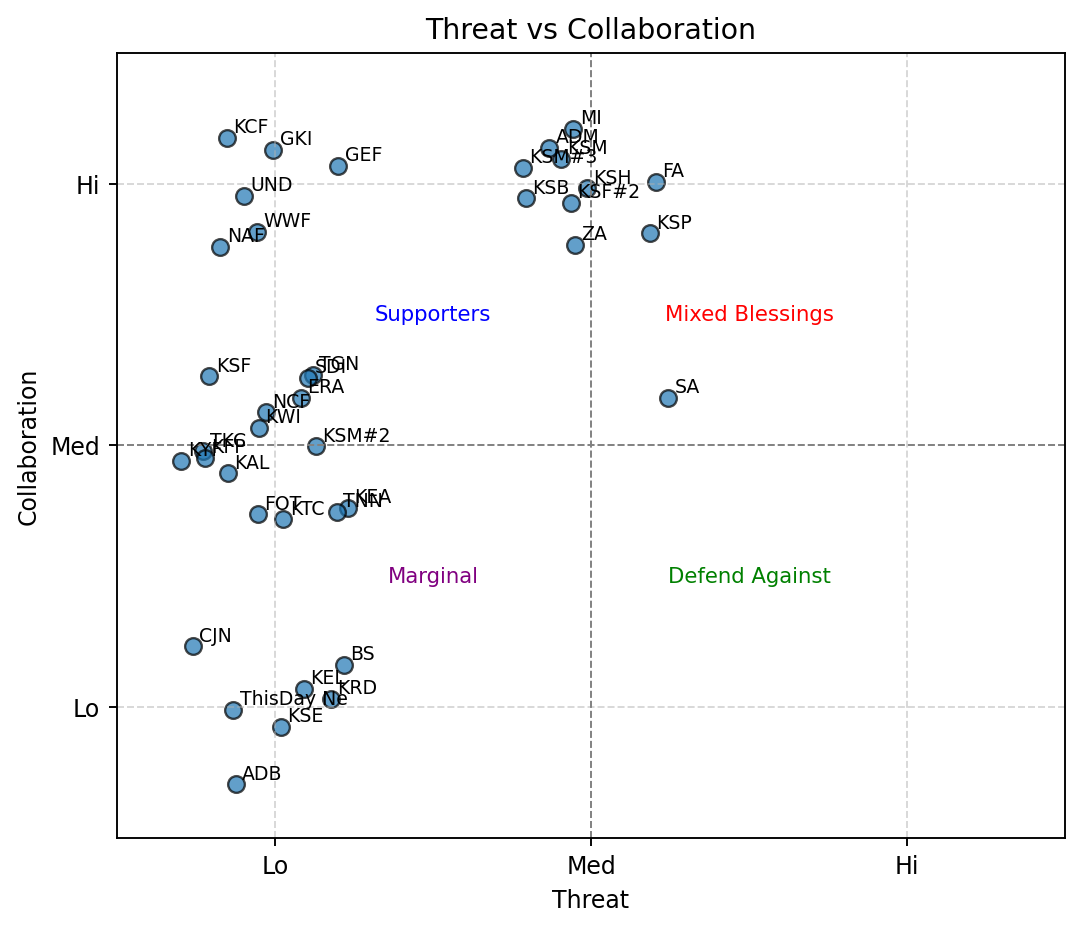

## 3) Stakeholder Identification, Analysis & Engagement

entity  \
0                                  Kaduna State Ministry of Environment   
1                                        Kaduna State House of Assembly   
2   Samuel Aruwan (Commissioner for Internal Security and Home Affairs)   
3                                               Green Kaduna Initiative   
4                                Kaduna State Forestry Products Company   
5                                 Kaduna Community Forestry Association   
6                                     World Wildlife Fund (WWF) Nigeria   
7                                        Kaduna State Media Corporation   
8                                      Kaduna State Forestry Commission   
9              Environmental Rights Action/Friends of the Earth Nigeria   
10                             Aisha D. Mohammed (Director of Forestry)   
11                                                Kaduna Timber Company   
12                                             Kaduna Women in Forestry   
13                  United Nations Development Programme (UNDP) Nigeria   
14                                                 The Kaduna Chronicle   
15                          Kaduna State Planning and Budget Commission   
16                                     Nigerian Conservation Foundation   
17            Musa Ibrahim (Chairman, Kaduna State Forestry Commission)   
18                                             Kaduna Agroforestry Ltd.   
19                                Kaduna Youth for Sustainable Forestry   
20                                    Global Environment Facility (GEF)   
21                                                 The Guardian Nigeria   
22                                 Kaduna State Ministry of Agriculture   
23                                         Friends of the Earth Nigeria   
24                     Fatima Aliyu (Director of Environmental Affairs)   
25                                          Kaduna Forest Products Ltd.   
26                                 Kaduna Environmental Awareness Group   
27                                      African Development Bank (AfDB)   
28                                                    ThisDay Newspaper   
29                  Kaduna State Environmental Protection Agency (KEPA)   
30                                              Climate Justice Nigeria   
31  Bashir Sani (Executive Secretary, Kaduna State Forestry Commission)   
32                                             Kaduna Eco-Forestry Ltd.   
33                                 Kaduna Rural Development Association   
34                 Norwegian Agency for Development Cooperation (Norad)   
35                                                 The Nation Newspaper   
36                           Kaduna State Bureau for Public Procurement   
37                                  Sustainable Development Initiatives   
38                       Zainab Abubakar (Head of Forestry Policy Unit)   

          abbr  \
0          KSM   
1          KSH   
2           SA   
3          GKI   
4          KSF   
5          KCF   
6          WWF   
7        KSM#2   
8        KSF#2   
9          ERA   
10         ADM   
11         KTC   
12         KWI   
13         UND   
14         TKC   
15         KSP   
16         NCF   
17          MI   
18         KAL   
19         KYF   
20         GEF   
21         TGN   
22       KSM#3   
23         FOT   
24          FA   
25         KFP   
26         KEA   
27         ADB   
28  ThisDay Ne   
29         KSE   
30         CJN   
31          BS   
32         KEL   
33         KRD   
34         NAF   
35         TNN   
36         KSB   
37         SDI   
38          ZA   

                                                                                                                                                                                                                                                                                Engagement Strategy  
0   Organize quarterly stakeholder meetings to di

## 4) Conclusions — Actionable Insights

# Actionable Insights
**Subject:** Climate Governance
**State:** Kaduna State
**Issue Focus:** Fund allocation to Forestry
**Generated:** 2025-10-05T02:21:30Z
# Climate Governance in Kaduna State: Fund Allocation to Forestry

## Challenges & Opportunities

### Challenges
1. **Deforestation and Environmental Degradation**: Kaduna State is experiencing significant environmental challenges, necessitating urgent action in climate governance and forestry fund allocation.
2. **Bureaucratic Inefficiencies**: Competing budget priorities and inefficiencies within government institutions hinder effective fund allocation for forestry initiatives.
3. **Vested Interests**: Resistance from stakeholders reliant on unsustainable logging and agricultural practices poses a significant threat to proposed reforms.
4. **Information Gaps**: Lack of comprehensive data on the economic valuation of forestry resources limits informed decision-making and advocacy efforts.

### Opportunities
1. **Upcoming Elections**: The political landscape presents a window for advocacy groups to push for increased funding and sustainable practices in forestry.
2. **Engaged Non-State Actors**: Local civil society organizations (CSOs), private sector actors, and international partners are increasingly involved in forestry initiatives, providing a collaborative foundation for advocacy.
3. **Economic Incentives**: Highlighting the potential economic benefits of sustainable forestry can garner support from both government and private sector stakeholders.

## Priority Stakeholders

1. **Kaduna State Ministry of Environment** (Core, Hi Power, Hi Interest)
   - **Importance**: Central to policy direction and fund allocation; has the power to influence budget priorities and engage with other stakeholders.
   
2. **Kaduna State Planning and Budget Commission** (Core, Hi Power, Hi Interest)
   - **Importance**: Responsible for aligning budget priorities with climate governance goals; can facilitate increased allocations for forestry.

3. **Kaduna State House of Assembly** (Core, Hi Power, Hi Interest)
   - **Importance**: Legislative support is crucial for policy changes and funding increases; can be influenced through data-driven advocacy.

4. **Kaduna Community Forestry Association** (Core, Med Power, Hi Interest)
   - **Importance**: Represents local community interests; can mobilize grassroots support and provide insights into local forestry needs.

5. **World Wildlife Fund (WWF) Nigeria** (Secondary, Med Power, Hi Interest)
   - **Importance**: International partner with expertise in sustainable forestry; can provide technical support and funding opportunities.

## Engagement Strategies

1. **Kaduna State Ministry of Environment**
   - **Strategy**: Organize quarterly stakeholder meetings to discuss forestry fund allocation, ensuring representation from local CSOs and private sector actors. Frame discussions around economic benefits and align with upcoming elections to garner political support.

2. **Kaduna State Planning and Budget Commission**
   - **Strategy**: Conduct strategic planning sessions to align budget priorities with climate governance goals. Emphasize the economic benefits of sustainable forestry in budget proposals to secure increased allocations.

3. **Kaduna State House of Assembly**
   - **Strategy**: Facilitate bi-monthly briefings with key assembly members to present data on the economic impact of forestry funding. Leverage upcoming elections to advocate for legislative support for increased allocations.

4. **Kaduna Community Forestry Association**
   - **Strategy**: Organize community forums to discuss local forestry needs and fund allocation priorities, ensuring their voices are heard in decision-making processes. Foster collaboration with local government to create pilot projects demonstrating sustainable practices.

5. **World Wildlife Fund (WWF) Nigeria**
   - **Strategy**: Establish a formal partnership to leverage WWF's expertise in sustainable forestry. Schedule joint project proposals for funding opportunities and co-host workshops to build local capacity in forestry management.

## Risks & Constraints

1. **Pushback from Vested Interests**: Engage with stakeholders reliant on unsustainable practices cautiously, emphasizing the long-term economic benefits of sustainable forestry to mitigate resistance.
2. **Bureaucratic Challenges**: Anticipate delays in decision-making processes; maintain flexibility in engagement strategies to adapt to changing political dynamics.
3. **Information Gaps**: Prioritize data collection and dissemination to inform advocacy efforts and enhance stakeholder understanding of forestry's economic value.

## Step-by-Step Recommendations

### Near-Term (30–90 Days)
1. **Conduct Stakeholder Mapping**: Finalize a detailed stakeholder analysis to identify key influencers and decision-makers within the government and private sector.
2. **Organize Initial Meetings**: Schedule introductory meetings with the Kaduna State Ministry of Environment and Planning and Budget Commission to discuss forestry fund allocation.
3. **Launch Awareness Campaign**: Initiate a public awareness campaign highlighting the economic benefits of sustainable forestry, leveraging local media partnerships.

### Medium-Term (3–9 Months)
1. **Establish Collaborative Platforms**: Create a multi-stakeholder platform for ongoing dialogue among government, CSOs, and private sector actors focused on forestry governance.
2. **Develop Joint Proposals**: Collaborate with WWF and other international partners to develop joint funding proposals aimed at enhancing local capacity for forestry management.
3. **Monitor and Evaluate Progress**: Implement a monitoring framework to assess the impact of advocacy efforts on fund allocation and stakeholder engagement, adjusting strategies as necessary.

By strategically engaging key stakeholders and leveraging upcoming political opportunities, Kaduna State can enhance its climate governance framework and secure necessary funding for sustainable forestry initiatives.


=== Report Build Summary ===
Markdown: /Users/olusojiapampa/Library/Mobile Documents/com~apple~CloudDocs/Documents/Proposals/PACE/PEAIM/PEAIM_clean_full/outputs/kaduna-state/PEA_Report.md
PDF:      PDF skipped (no pandoc/reportlab by design).


In [ ]:
# === 06) Final Markdown Report — Intelligent PEA Workbook (Markdown only) ===
# Sections:
# 1) Project Title
# 2) Context (from pea_summaries.csv)
# 3) Stakeholder Maps (PNG from outputs/<state[-state]>)
# 4) Stakeholder Identification, Analysis & Engagement (from pea_stakeholder_scores_mapping_engage.csv)
# 5) Conclusions — Actionable Insights (from PEA_Actionable_Insights.md)

import re, json, os
from pathlib import Path
from datetime import datetime, timezone
import pandas as pd
from IPython.display import display, Markdown, Image

# ---------- Helpers ----------
def find_project_root(max_up=8):
    p = Path.cwd()
    for _ in range(max_up):
        if (p / "configs").exists() and ((p / "src").exists() or (p / "notebooks").exists()):
            return p
        p = p.parent
    return Path.cwd()

def slugify(s: str) -> str:
    return re.sub(r"[^0-9a-zA-Z]+", "-", (s or "").strip().lower()).strip("-") or "unknown"

def prefer_state_output_dir(root: Path, state_name: str) -> Path:
    """
    Prefer outputs/<slug>-state if slug doesn't already end with '-state'.
    If slug already ends with '-state' (e.g., from 'Kaduna State' → 'kaduna-state'),
    do NOT append another '-state'.
    """
    slug = slugify(state_name)
    candidates = []
    if slug.endswith("-state"):
        # already has -state: try that, then the plain slug as a fallback
        candidates = [root / "outputs" / slug, root / "outputs" / slug.replace("-state", "")]
    else:
        # try <slug>-state first, then plain slug
        candidates = [root / "outputs" / f"{slug}-state", root / "outputs" / slug]

    for p in candidates:
        if p.exists():
            return p

    # Create the first preferred candidate if none exist
    candidates[0].mkdir(parents=True, exist_ok=True)
    return candidates[0]

# ---------- Resolve project + current state ----------
ROOT = find_project_root()
state = "kaduna"  # harmless fallback; will be replaced by run.yaml if present
try:
    import yaml
    cfg = yaml.safe_load((ROOT / "configs" / "run.yaml").read_text(encoding="utf-8"))
    state = cfg.get("current_state", state)
except Exception:
    pass

OUT_DIR = prefer_state_output_dir(ROOT, state)
print(f"Using outputs dir: {OUT_DIR}")

# ---------- Gather file paths ----------
pea_csv     = OUT_DIR / "pea_summaries.csv"
eng_csv     = OUT_DIR / "pea_stakeholder_scores_mapping_engage.csv"
map_pi      = OUT_DIR / "map_power_interest.png"
map_tc      = OUT_DIR / "map_threat_collab.png"
insights_md = OUT_DIR / "PEA_Actionable_Insights.md"   # LLM output picked up here
report_md   = OUT_DIR / "PEA_Report.md"

# ---------- Load context ----------
context = {"subject":"", "state":"", "issue":"", "summary":""}
if pea_csv.exists():
    try:
        df_pea = pd.read_csv(pea_csv)
        row = df_pea.sort_values("timestamp_utc").tail(1).iloc[0] if "timestamp_utc" in df_pea.columns else df_pea.tail(1).iloc[0]
        context = {
            "subject": str(row.get("subject","")).strip(),
            "state":   str(row.get("state","")).strip(),
            "issue":   str(row.get("issue_focus","")).strip(),
            "summary": str(row.get("summary","")).strip(),
        }
    except Exception as e:
        display(Markdown(f"**⚠️ Could not read context from** `{pea_csv.name}`: `{e}`"))
else:
    display(Markdown(f"**⚠️ Context file not found:** `{pea_csv}`"))

# ---------- Load stakeholder table (only 3 columns for display/report) ----------
df_eng_display = pd.DataFrame()
if eng_csv.exists():
    try:
        df_eng = pd.read_csv(eng_csv)

        # Normalize column names we care about
        cols_lower = {c.lower(): c for c in df_eng.columns}
        col_entity = cols_lower.get("entity", "entity")
        col_abbr   = cols_lower.get("abbr", "abbr")

        # Strategy column could be "Engagement Strategy" or "engagement_strategy"
        col_strat  = None
        for c in df_eng.columns:
            if c.strip().lower() == "engagement strategy" or c.strip().lower() == "engagement_strategy":
                col_strat = c
                break
        if col_strat is None:
            # create empty strategy column if missing
            col_strat = "Engagement Strategy"
            df_eng[col_strat] = ""

        # Build a slim view with ONLY the desired columns (in that order)
        keep = [col_entity, col_abbr, col_strat]
        # If some are missing, fill as blank
        for c in keep:
            if c not in df_eng.columns:
                df_eng[c] = ""
        df_eng_display = df_eng[keep].copy()
        # For markdown export, make readable header names
        df_eng_display = df_eng_display.rename(columns={col_entity:"entity",
                                                        col_abbr:"abbr",
                                                        col_strat:"Engagement Strategy"})
    except Exception as e:
        display(Markdown(f"**⚠️ Could not read stakeholder engagement file** `{eng_csv.name}`: `{e}`"))
else:
    display(Markdown(f"**⚠️ Engagement file not found:** `{eng_csv}`"))

# ---------- Load actionable insights (if present) ----------
insights_text = ""
if insights_md.exists():
    try:
        insights_text = insights_md.read_text(encoding="utf-8").strip()
    except Exception as e:
        display(Markdown(f"**⚠️ Could not read actionable insights from** `{insights_md.name}`: `{e}`"))
else:
    insights_text = "_(Add actionable insights by creating `PEA_Actionable_Insights.md` in the outputs folder.)_"

# ---------- Render INLINE ----------
# 1) Title + Date
display(Markdown("# Political Economy Analysis Workbook"))
display(Markdown(f"**Date:** {datetime.now(timezone.utc).isoformat(timespec='seconds')}"))

# 2) Context
display(Markdown("## 1) Context"))
display(Markdown(
    f"**Subject:** {context['subject'] or '—'}  \n"
    f"**State:** {context['state'] or '—'}  \n"
    f"**Issue Focus:** {context['issue'] or '—'}"
))
display(Markdown("**10-line Summary:**"))
display(Markdown(context['summary'] or "—"))

# 3) Maps
display(Markdown("## 2) Stakeholder Maps"))
if map_pi.exists():
    display(Markdown("**Power vs. Interest**"))
    display(Image(filename=str(map_pi)))
else:
    display(Markdown(f"**⚠️ Missing map:** `{map_pi.name}`"))

if map_tc.exists():
    display(Markdown("**Threat vs. Collaboration**"))
    display(Image(filename=str(map_tc)))
else:
    display(Markdown(f"**⚠️ Missing map:** `{map_tc.name}`"))

# 4) Table (only entity, abbr, Engagement Strategy)
display(Markdown("## 3) Stakeholder Identification, Analysis & Engagement"))
if not df_eng_display.empty:
    with pd.option_context("display.max_rows", None, "display.max_colwidth", 1000):
        display(df_eng_display)
else:
    display(Markdown(f"**⚠️ No stakeholder engagement rows found in** `{eng_csv.name}`"))

# 5) Conclusions — Actionable Insights
display(Markdown("## 4) Conclusions — Actionable Insights"))
display(Markdown(insights_text or "—"))

# ---------- Write Markdown file (no PDF) ----------
lines = []
lines.append("# Political Economy Analysis Workbook\n")
lines.append(f"**Date:** {datetime.now(timezone.utc).isoformat(timespec='seconds')}\n")
lines.append("\n## 1) Context\n")
lines.append(f"- **Subject:** {context['subject'] or '—'}\n")
lines.append(f"- **State:** {context['state'] or '—'}\n")
lines.append(f"- **Issue Focus:** {context['issue'] or '—'}\n")
lines.append("\n**10-line Summary:**\n\n")
lines.append((context['summary'] or '—') + "\n")

lines.append("\n## 2) Stakeholder Maps\n")
lines.append(f"- Power vs. Interest: `{map_pi.name if map_pi.exists() else 'MISSING'}`\n")
lines.append(f"- Threat vs. Collaboration: `{map_tc.name if map_tc.exists() else 'MISSING'}`\n")

lines.append("\n## 3) Stakeholder Identification, Analysis & Engagement\n")
if not df_eng_display.empty:
    # Only the three chosen columns in the exported markdown table
    df_md = df_eng_display.to_markdown(index=False)
    lines.append(df_md + "\n")
else:
    lines.append(f"_No engagement table found in `{eng_csv.name}`._\n")

lines.append("\n## 4) Conclusions — Actionable Insights\n")
lines.append(insights_text or "—")
lines.append("\n")

OUT_DIR.mkdir(parents=True, exist_ok=True)
report_md.write_text("\n".join(lines), encoding="utf-8")

print("\n=== Report Build Summary ===")
print("Markdown:", report_md)
print("PDF:      PDF skipped (no pandoc/reportlab by design).")